In [2]:
#Import used
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import math

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.12.0-rc1


In [19]:
test_results = {}
hists = {}

In [18]:
def plot_loss(history, titleString, learningRate, epoch):
    fig1, ax1 = plt.subplots()
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    print(min(history.history['loss']), max(history.history['loss']))
    ax1.set_ylim([min(min(history.history['val_loss']), min(history.history['loss'])), max(max(history.history['loss']), max(history.history['val_loss']))])
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Error [Price]')
    ax1.set_title(f"{titleString} {learningRate} LR {epoch}E")
    ax1.legend()
    ax1.grid(True)
    fig1.savefig(f"Linear Results/Final {titleString} {learningRate} LR {epoch}E.png")

In [5]:
def runLinearModel(learningRate=0.05, fullData=False, epoch=30, kfold=False, train=None, test=None, i=0):
    if kfold:
        train_dataset = train
        test_dataset = test
        if fullData:
            titleString = f"Lin Reg Full Dataset {i+1}th fold"
        else:
            titleString = f"Lin Reg 15k+ Dataset {i+1}th fold"
    elif fullData:
        train_dataset = pd.read_csv("lr_nn_data/full_train.csv")
        test_dataset = pd.read_csv("lr_nn_data/full_test.csv")
        titleString = "Lin Reg Full Dataset"
    else:
        train_dataset = pd.read_csv("lr_nn_data/above15k_train.csv")
        test_dataset = pd.read_csv("lr_nn_data/above15k_test.csv")
        titleString = "Lin Reg 15k+ Dataset"
    
    train_dataset = train_dataset.drop(columns=train_dataset.columns[0])
    test_dataset = test_dataset.drop(columns=test_dataset.columns[0])

    #Establishes features and labels
    train_features = train_dataset.copy()
    test_features = test_dataset.copy()

    train_labels = train_features.pop('price')
    test_labels = test_features.pop('price')

    model_params = np.array(train_features)
    #Creates the normalizer for the parameters
    normalizer = tf.keras.layers.Normalization(input_shape=[len(train_dataset.columns) - 1,], axis=-1)
    normalizer.adapt(model_params) 

    #Creates the model with multiple layers,
    #This is something we can change, but for now it works and doesn't take too long
    linear_model = tf.keras.Sequential([
        normalizer,
        layers.Dense(units=16),
        layers.Dense(units=32),
        layers.Dense(units=5)
    ])

    #We can change the optimization model to something else Adam was just recommneded based on Tensor Flow's webiste on Linear Regression
    #Also the learning rate and loss can be changed as well but a 0.1 learning rate seemed a bit too high and caused validation to freak out
    linear_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learningRate),
        loss='mean_absolute_error')
    

    #Trains the model, we can change the number of epochs, but based on my running it appears to flatline around this value
    history = linear_model.fit(
        train_features,
        train_labels,
        epochs=epoch,
        # Suppress logging.
        verbose=0,
        # Calculate validation results on 20% of the training data.
        validation_split = 0.2)
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    test_result = linear_model.evaluate(
    test_features,
    test_labels, verbose=0)

    return (test_result, history, titleString, hist)

        

In [6]:
part1 = pd.read_csv("lr_nn_data/above15k_train.csv")
part2 = pd.read_csv("lr_nn_data/above15k_test.csv")

full = pd.concat([part1, part2], ignore_index=True)
full = full.sample(frac=1)
full = full.sample(frac=1)
full = full.sample(frac=1)


In [7]:
##Cross Validation for LinReg 15k+ Dataset

def cross_validation(lr, epoch, cutOff):
    print(f"Testing Learning Rate {lr}")
    avgErrors = []
    histsForLR = []
    for i in range(0,5):
        print(f"Testing the {i+1}th fifth")
        test_dataset = full.iloc[i*cutOff:cutOff*(i+1)]
        train_dataset = full.drop(test_dataset.index)

        test_result, history, titleString, hist = runLinearModel(lr, False, epoch, kfold=True, train=train_dataset, test=test_dataset, i=i)
        plot_loss(history, titleString, lr, epoch)
        print(f"Error for lr {lr}, {i+1}th fifth is {test_result}")
        avgErrors.append(test_result)
        histsForLR.append(hist)
    finalError = sum(avgErrors) / 5
    return finalError, avgErrors, histsForLR

In [8]:
epoch = 35
cverrors = {}
cvhists = {}
cutOff = math.floor(len(full) / 5)

Testing Learning Rate 0.1
Testing the 1th fifth
3949.567138671875 4677.6728515625
Error for lr 0.1, 1th fifth is 3854.895263671875
Testing the 2th fifth
3916.907958984375 4709.017578125
Error for lr 0.1, 2th fifth is 11852.216796875
Testing the 3th fifth
3932.635498046875 4624.36083984375
Error for lr 0.1, 3th fifth is 3863.894287109375
Testing the 4th fifth
3900.096435546875 4623.109375
Error for lr 0.1, 4th fifth is 3873.5693359375
Testing the 5th fifth
3911.85302734375 4616.17431640625
Error for lr 0.1, 5th fifth is 3856.47265625


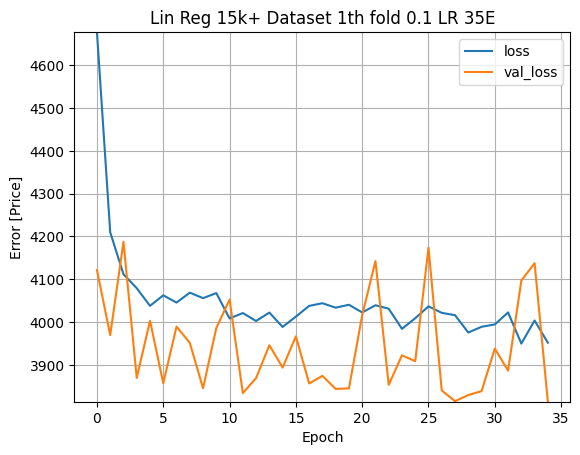

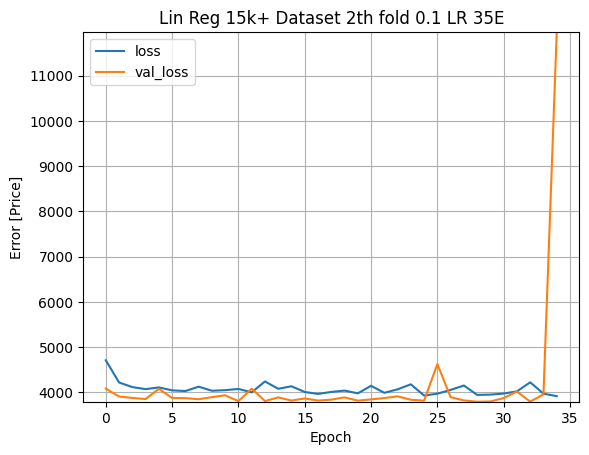

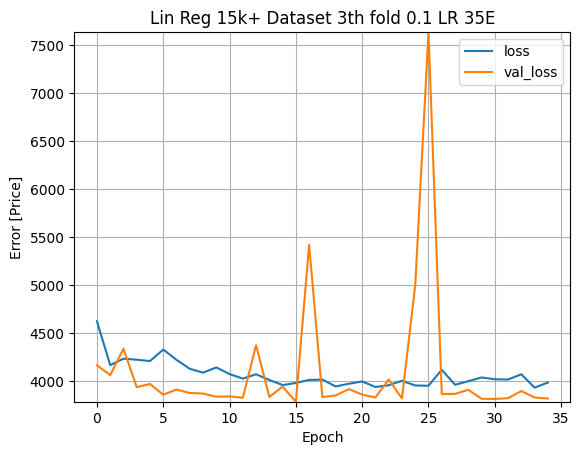

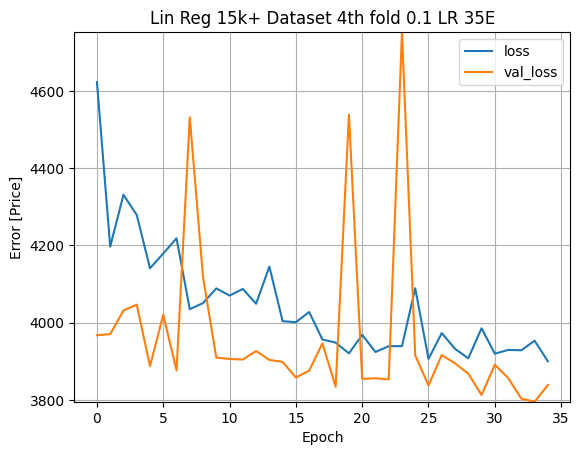

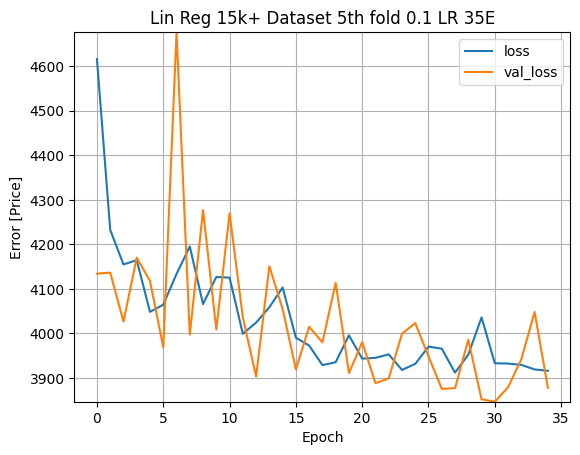

In [9]:
lr = 0.1
finalError, avgErrors, histsForLR = cross_validation(lr, epoch, cutOff)
cverrors[lr] = (finalError, avgErrors)
cvhists[lr] = histsForLR

Testing Learning Rate 0.075
Testing the 1th fifth
3870.6572265625 4582.2880859375
Error for lr 0.075, 1th fifth is 3852.628662109375
Testing the 2th fifth
3882.926025390625 4479.34765625
Error for lr 0.075, 2th fifth is 3833.79248046875
Testing the 3th fifth
3856.7158203125 4570.0869140625
Error for lr 0.075, 3th fifth is 3902.303955078125
Testing the 4th fifth
3858.151611328125 4532.9423828125
Error for lr 0.075, 4th fifth is 3869.2734375
Testing the 5th fifth
3868.114013671875 4578.33544921875
Error for lr 0.075, 5th fifth is 3832.42138671875


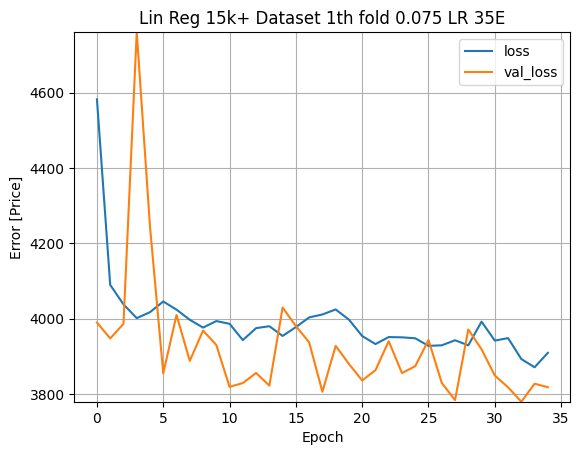

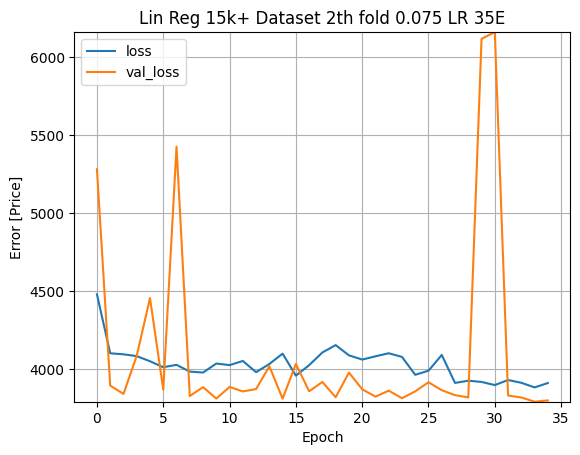

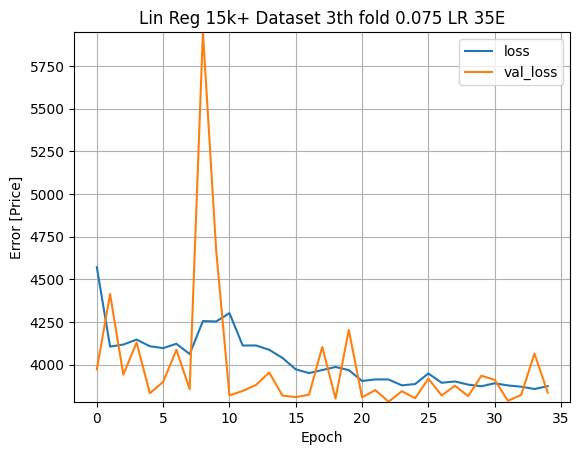

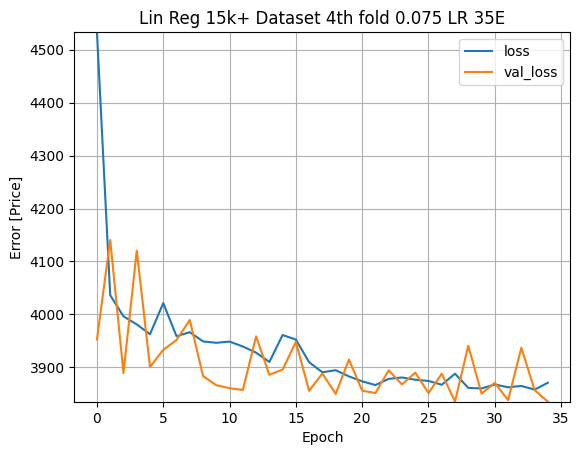

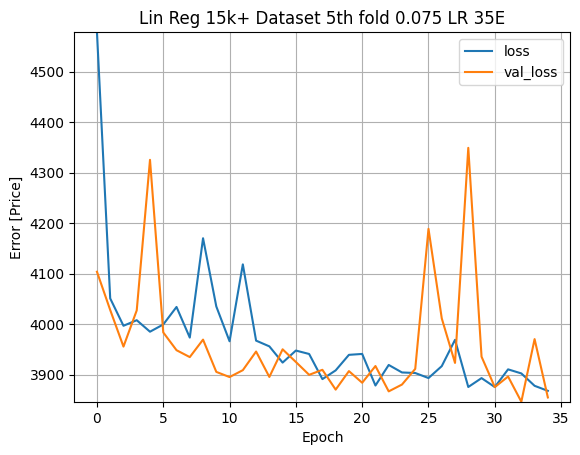

In [10]:
lr = 0.075
finalError, avgErrors, histsForLR = cross_validation(lr, epoch, cutOff)
cverrors[lr] = (finalError, avgErrors)
cvhists[lr] = histsForLR

Testing Learning Rate 0.05
Testing the 1th fifth
3834.33349609375 4543.5634765625
Error for lr 0.05, 1th fifth is 3816.140380859375
Testing the 2th fifth
3849.6787109375 4522.86669921875
Error for lr 0.05, 2th fifth is 3893.46630859375
Testing the 3th fifth
3819.548095703125 4454.82861328125
Error for lr 0.05, 3th fifth is 3874.754638671875
Testing the 4th fifth
3828.662353515625 4505.6337890625
Error for lr 0.05, 4th fifth is 3980.445068359375
Testing the 5th fifth
3829.01171875 4432.1015625
Error for lr 0.05, 5th fifth is 3855.617919921875


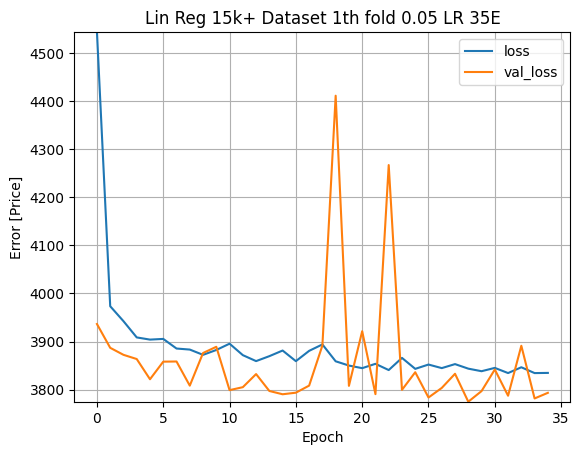

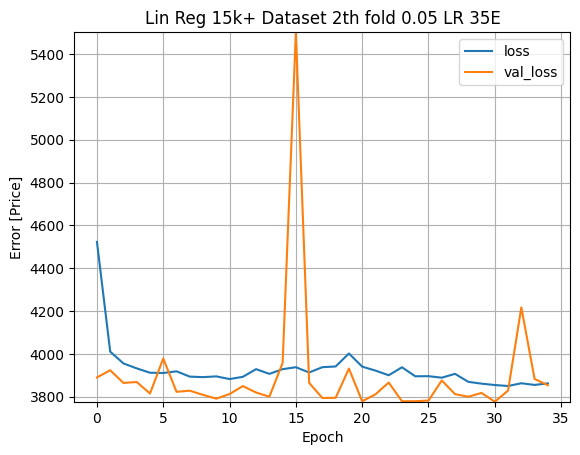

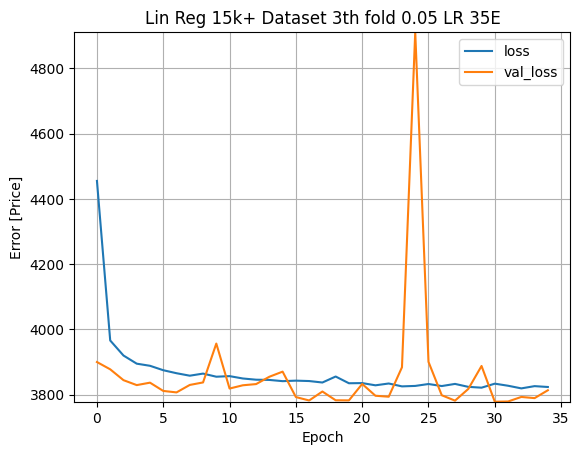

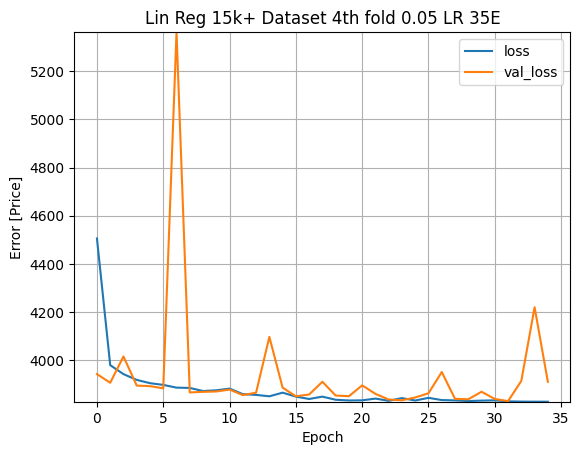

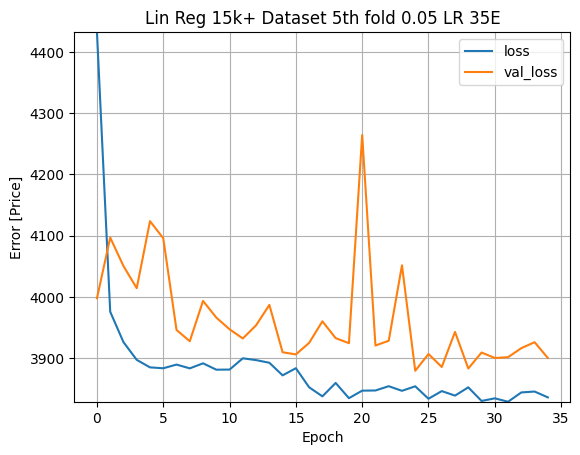

In [11]:
lr = 0.05
finalError, avgErrors, histsForLR = cross_validation(lr, epoch, cutOff)
cverrors[lr] = (finalError, avgErrors)
cvhists[lr] = histsForLR

Testing Learning Rate 0.01
Testing the 1th fifth
3793.11962890625 4658.84716796875
Error for lr 0.01, 1th fifth is 3808.36669921875
Testing the 2th fifth
3785.024658203125 4609.62060546875
Error for lr 0.01, 2th fifth is 3777.9013671875
Testing the 3th fifth
3783.541748046875 4624.7138671875
Error for lr 0.01, 3th fifth is 3818.1279296875
Testing the 4th fifth
3787.13671875 4575.140625
Error for lr 0.01, 4th fifth is 3877.440673828125
Testing the 5th fifth
3779.03515625 4544.4912109375
Error for lr 0.01, 5th fifth is 3854.115478515625


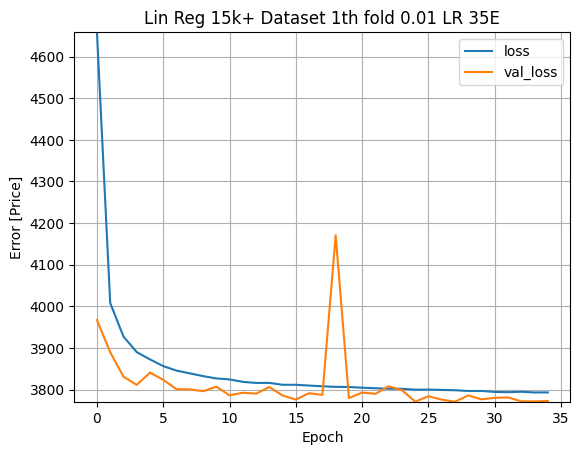

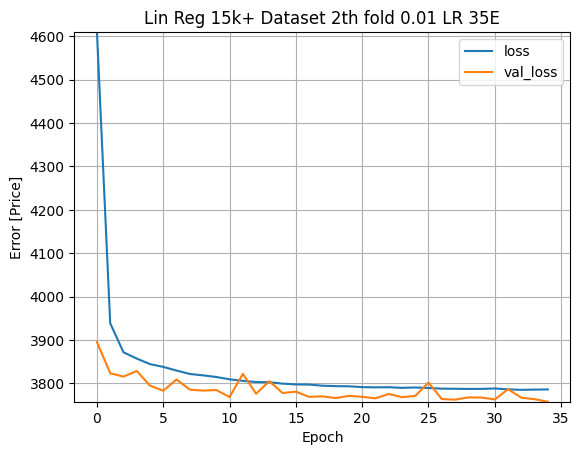

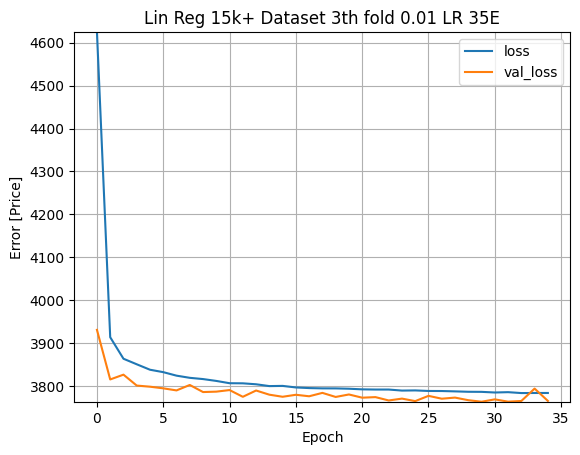

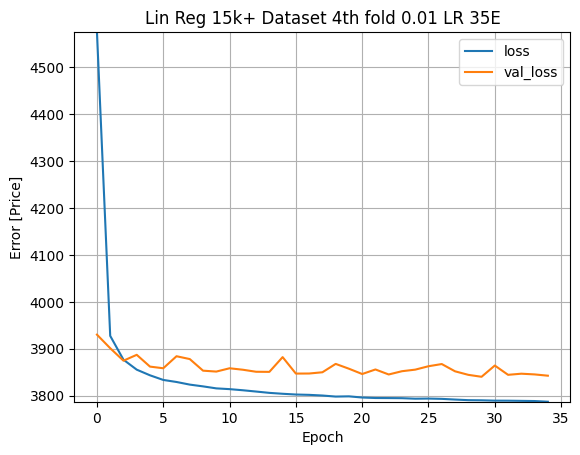

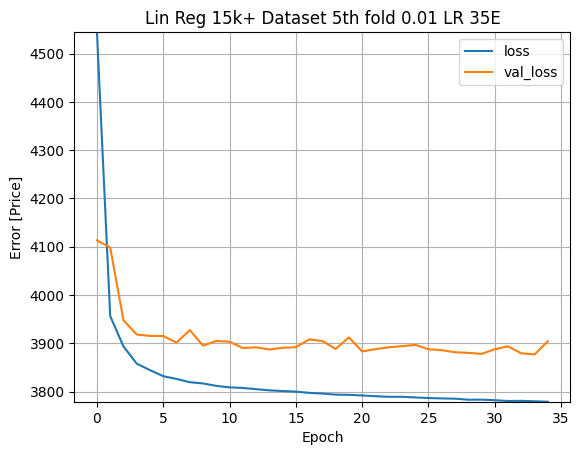

In [12]:
lr = 0.01
finalError, avgErrors, histsForLR = cross_validation(lr, epoch, cutOff)
cverrors[lr] = (finalError, avgErrors)
cvhists[lr] = histsForLR

Testing Learning Rate 0.005
Testing the 1th fifth
3805.179931640625 4675.24853515625
Error for lr 0.005, 1th fifth is 3870.4365234375
Testing the 2th fifth
3795.499755859375 4789.11865234375
Error for lr 0.005, 2th fifth is 3790.192138671875
Testing the 3th fifth
3786.765625 4753.1806640625
Error for lr 0.005, 3th fifth is 3841.945556640625
Testing the 4th fifth
3801.3984375 4729.3125
Error for lr 0.005, 4th fifth is 3906.343505859375
Testing the 5th fifth
3788.6923828125 4740.12109375
Error for lr 0.005, 5th fifth is 3837.560791015625


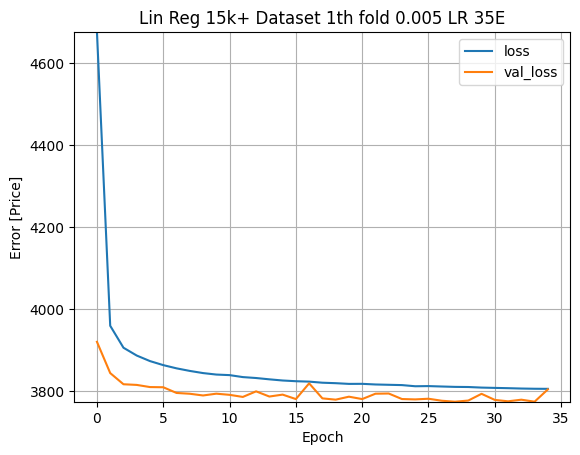

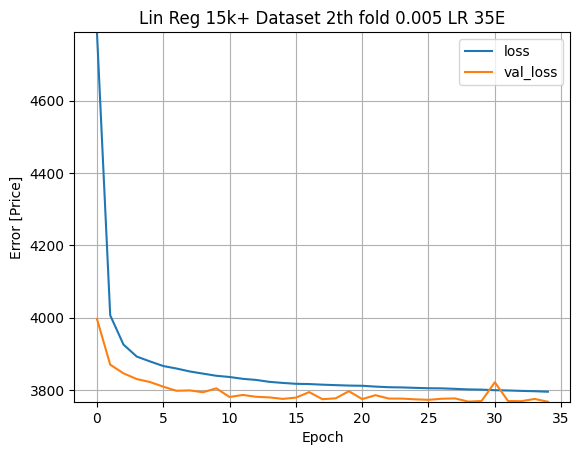

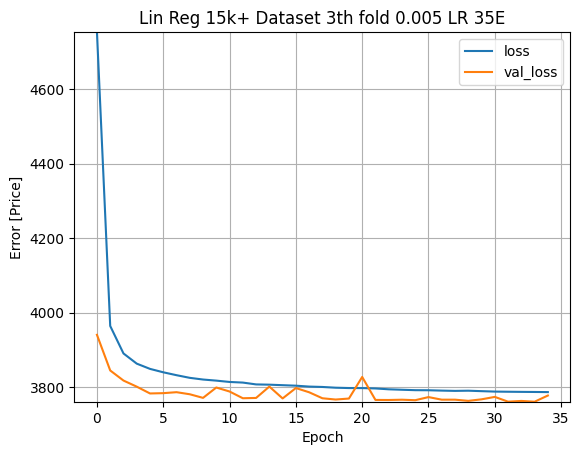

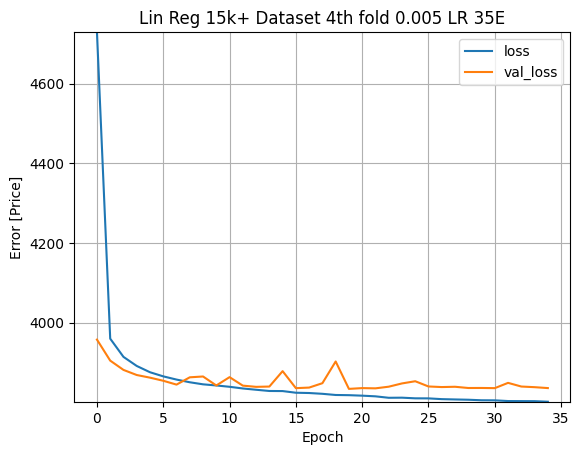

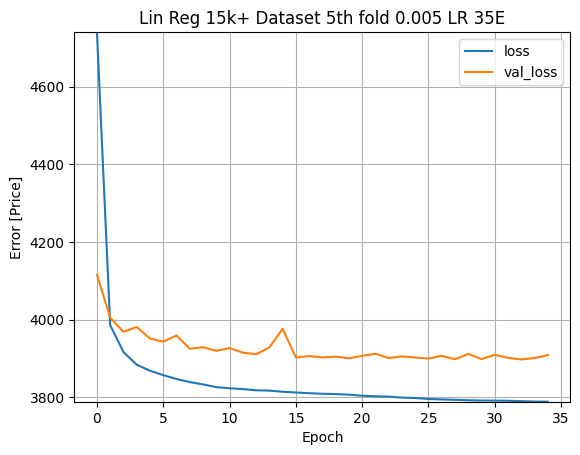

In [13]:
lr = 0.005
finalError, avgErrors, histsForLR = cross_validation(lr, epoch, cutOff)
cverrors[lr] = (finalError, avgErrors)
cvhists[lr] = histsForLR

In [14]:
cverrors

{0.1: (5460.20966796875,
  [3854.895263671875,
   11852.216796875,
   3863.894287109375,
   3873.5693359375,
   3856.47265625]),
 0.075: (3858.083984375,
  [3852.628662109375,
   3833.79248046875,
   3902.303955078125,
   3869.2734375,
   3832.42138671875]),
 0.05: (3884.08486328125,
  [3816.140380859375,
   3893.46630859375,
   3874.754638671875,
   3980.445068359375,
   3855.617919921875]),
 0.01: (3827.1904296875,
  [3808.36669921875,
   3777.9013671875,
   3818.1279296875,
   3877.440673828125,
   3854.115478515625]),
 0.005: (3849.295703125,
  [3870.4365234375,
   3790.192138671875,
   3841.945556640625,
   3906.343505859375,
   3837.560791015625])}

In [15]:
for lr in cverrors.keys():
    print(f"The avgerage error for learning rate {lr} is {cverrors[lr][0]}")

The avgerage error for learning rate 0.1 is 5460.20966796875
The avgerage error for learning rate 0.075 is 3858.083984375
The avgerage error for learning rate 0.05 is 3884.08486328125
The avgerage error for learning rate 0.01 is 3827.1904296875
The avgerage error for learning rate 0.005 is 3849.295703125


Learning rate is 0.01
3782.921630859375 4609.3623046875


3819.60693359375

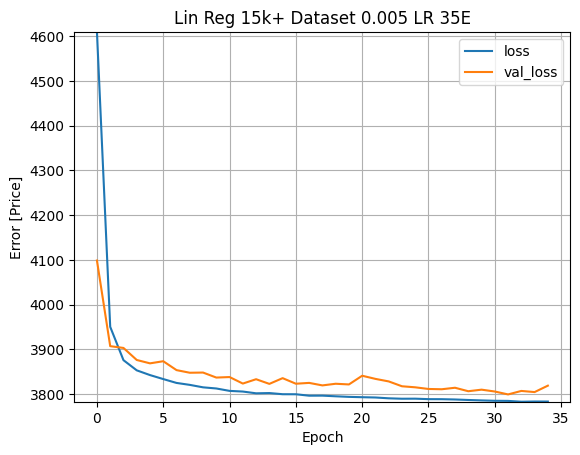

In [26]:
learningRate = 0.01
epoch = 35

test_result, history, titleString, hist = runLinearModel(learningRate, False, epoch)
plot_loss(history, titleString, lr, epoch)
test_results[f"Lin Reg 15k+ {lr}LR {epoch}E"] = test_result
test_result

3782.921630859375 4609.3623046875


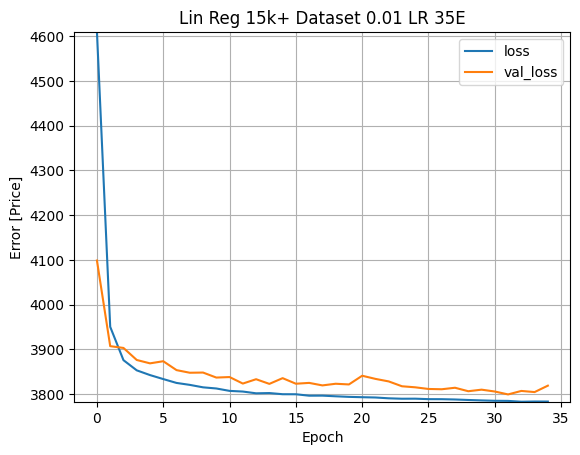

In [30]:
plot_loss(history, "Lin Reg 15k+ Dataset", 0.01, 35)

3789.959228515625 4760.61181640625


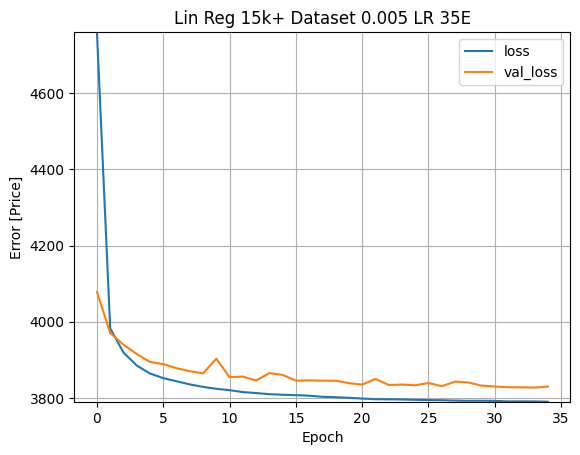

In [21]:
learningRate = 0.005
epoch = 35

test_result, history, titleString, hist = runLinearModel(learningRate, False, epoch)
plot_loss(history, titleString, lr, epoch)
test_results[f"Lin Reg 15k+ {lr}LR {epoch}E"] = test_result

In [28]:
test_results["Lin Reg 15k+ 0.01LR 35E"] = 3819.60693359375
test_results["Lin Reg 15k+ 0.005LR 35E"] = 3813.48876953125
test_results

{'Lin Reg 15k+ 0.005LR 35E': 3813.48876953125,
 'Lin Reg 15k+ 0.01LR 35E': 3819.60693359375}